In [2]:
from logging import DEBUG, INFO
from sdsstools import get_logger
from sdsstools.logger import StreamFormatter

logger = get_logger("astro.net")
logger.sh.setLevel(DEBUG)
logger.sh.formatter = StreamFormatter(fmt='%(asctime)s %(name)s \033[1m%(message)s\033[21m')
logger.debug("hello world")


2023-02-02 12:48:21,604 astro.net [DEBUG]: hello world


In [7]:
import astropy
import astrometry

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={6},
    )
)
# only first iteration
logodds_callback = astrometry.Action.STOP
# full
#logodds_callback = astrometry.Action.CONTINUE


In [8]:
from cluplus.proxy import invoke
from lvmtipo.actors import lvm

telescope_subsystem_name = "sci"
tss = await lvm.from_string(telescope_subsystem_name).start()
await tss.pwi.setConnected(True)
await invoke(tss.pwi.status(), tss.km.status())


[{'is_tracking': False,
  'is_connected': True,
  'is_slewing': False,
  'is_enabled': True,
  'ra_j2000_hours': 16.9287987366103,
  'dec_j2000_degs': -73.9950970638429,
  'ra_apparent_hours': 16.9760604483313,
  'dec_apparent_degs': -74.0275786416657,
  'altitude_degs': 45.0,
  'azimuth_degs': 180.0,
  'field_angle_rate_at_target_degs_per_sec': 0.0,
  'field_angle_here_degs': 1.00466876465367e-05,
  'field_angle_at_target_degs': 0.0,
  'axis0': {'dist_to_target_arcsec': 0.0,
   'is_enabled': True,
   'position_degs': 180.0,
   'rms_error_arcsec': 0.0,
   'servo_error_arcsec': 0.0},
  'axis1': {'dist_to_target_arcsec': 0.0,
   'is_enabled': True,
   'position_degs': 45.0,
   'rms_error_arcsec': 0.0,
   'servo_error_arcsec': 0.0},
  'model': {'filename': '',
   'num_points_enabled': 0,
   'num_points_total': 0,
   'rms_error_arcsec': 0.0},
  'geometry': 0},
 {'Reachable': True,
  'AtHome': True,
  'Moving': False,
  'PositionSwitchStatus': 254,
  'Position': -135.0,
  'DeviceEncoder': {

2023-02-02 13:09:07,711 astro.net [DEBUG]: Expose
DEBUG:astro.net:Expose


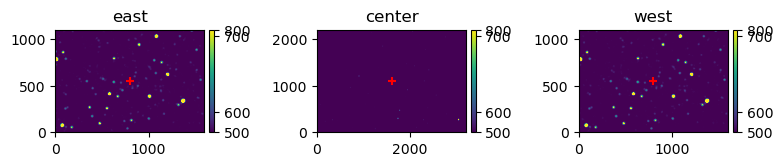

In [30]:
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from plotimg import plot_images

# define source detection
source_detection = SepSourceDetection()
#source_detection = DaophotSourceDetection()

logger.debug("Expose")
filenames = (await tss.agc.expose(15)).flatten().unpack("*.filename") 
images = [Image.from_file(f) for f in filenames]
image = images[0]

plot_images(images)


In [31]:
arcsec_per_pixel=1/image.header['PIXSCALE']*image.header['BINX']

print(f"{image.header['RA']=}")
print(f"{image.header['DEC']=}")
print(f"{arcsec_per_pixel=}")

logger.debug("Source detect")
image = await source_detection(image)
if image.catalog is None:
    logger.warning("No catalog found in image.")
    
logger.debug("Sort")

source_count = 17
sources = image.catalog
sources.sort("peak")
sources.reverse()
sources = sources[:source_count]
#print(sources)

logger.debug("Solve start")
solution = solver.solve(
    stars_xs=sources['x'],
    stars_ys=sources['y'],
    size_hint=astrometry.SizeHint(
        lower_arcsec_per_pixel=arcsec_per_pixel-0.5,
        upper_arcsec_per_pixel=arcsec_per_pixel+0.5,
    ),
    position_hint=astrometry.PositionHint(
        ra_deg=image.header['RA'],
        dec_deg=image.header['DEC'],
        radius_deg=1,
    ),
    solution_parameters = astrometry.SolutionParameters(
      solve_id=None,
      tune_up_logodds_threshold=14.0, # None disables tune-up (SIP distortion)
      output_logodds_threshold=21.0,
      logodds_callback=lambda logodds_list: logodds_callback
    )
)
logger.debug("Solve done")

if solution.has_match():
    print(f"{solution.best_match().center_ra_deg=}")
    print(f"{solution.best_match().center_dec_deg=}")
    print(f"{solution.best_match().scale_arcsec_per_pixel=}")
    wcs = astropy.wcs.WCS(solution.best_match().wcs_fields)
    pixels = wcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
    #print(f"{wcs}")

2023-02-02 13:09:23,995 astro.net [DEBUG]: Source detect
DEBUG:astro.net:Source detect
2023-02-02 13:09:24,130 astro.net [DEBUG]: Sort
DEBUG:astro.net:Sort
2023-02-02 13:09:24,131 astro.net [DEBUG]: Solve start
DEBUG:astro.net:Solve start


image.header['RA']=258.33511865427
image.header['DEC']=-74.0043586891314
arcsec_per_pixel=0.9910669005614712


2023-02-02 13:09:24,258 astro.net [DEBUG]: Solve done
DEBUG:astro.net:Solve done


In [32]:
print(f"{wcs}")

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 253.4260123989683  -73.56763235699492  
CRPIX : 914.8002147831085  364.6126930969446  
CD1_1 CD1_2  : 0.000256972122540076  -0.00010657292525348  
CD2_1 CD2_2  : 0.000111130052958858  0.000257274928695366  
NAXIS : 0  0


In [33]:
import time

import numpy as np
from matplotlib.colors import LogNorm

from reproject import reproject_interp

start_time = time.time()
rep_east = reproject_interp((images[0].data, images[0].header), wcs, shape_out=(2000,2000), return_footprint=False)
print(time.time() - start_time)

Set OBSGEO-B to    49.396500 from OBSGEO-[XYZ].
Set OBSGEO-H to      560.001 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    49.396500 from OBSGEO-[XYZ].
Set OBSGEO-H to      560.001 from OBSGEO-[XYZ]'.
2023-02-02 13:09:40,316 py.warnings [WARNING]: 'WCS.all_world2pix' failed to converge to the requested accuracy. (UserWarning)
After 20 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))



6.325290679931641


[[560 552 575 ... 508 529 562]
 [576 565 574 ... 531 547 553]
 [512 555 555 ... 582 518 565]
 ...
 [545 510 519 ... 549 571 562]
 [563 571 588 ... 580 556 550]
 [574 547 557 ... 563 537 550]]


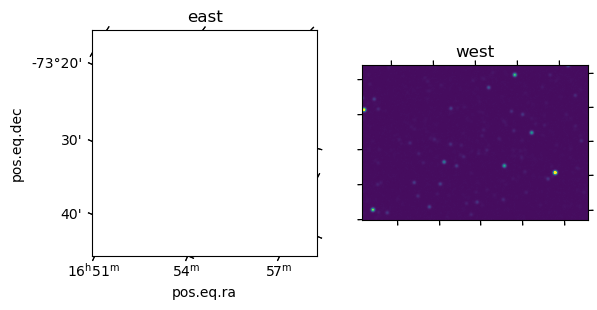

In [34]:
from astropy.wcs import WCS
import matplotlib.pyplot as plt

ax1 = plt.subplot(1,2,1, projection=wcs)
ax1.imshow(rep_east, origin='lower', vmin=100., vmax=400.)
#ax1.coords['ra'].set_axislabel('Right Ascension')
#ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('east')

ax2 = plt.subplot(1,2,2, projection=WCS(image.header))
ax2.imshow(image.data, origin='lower', vmin=500., vmax=2000.)
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('west')

print(image.data)

In [20]:
import time

import numpy as np
from matplotlib.colors import LogNorm

from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs

wcs_out, shape_out= find_optimal_celestial_wcs((image.data, image.header))



TypeError: input_shape should either be an HDU object or a tuple of (array-or-shape, WCS) or (array-or-shape, Header)

In [ ]:
for img in images:
   start_time = time.time()
   rep_east = reproject_interp((img.data, img.header), wcs_out, shape_out=shape_out, return_footprint=False)
   print(time.time() - start_time)
